# Sparkify: ML  model implementation  


In this notebook we do the  data analysis with the medium data set on IBM watson studio

In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.object.networklayer.com',
    'service_id': 'iam-ServiceId-ae8e0d1e-8efa-XXXXX',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'fH1YFBK2C84k1Hw0RU1oEXXXXX'
}

configuration_name = 'os_483417c1de3948ecb5d662XXXXXX'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-oamce1b1oti8al'))
# df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190613205636-0000
KERNEL_ID = 2ddf40a4-42f9-4b8a-b71d-38f52f75f63e


In [2]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf, desc, asc, avg, col, concat, desc, explode, lit, min, max, split,count
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum

import datetime
from time import time

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from functools import reduce


In [3]:
# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler,StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier,LinearSVC 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [4]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [5]:
#df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkifyad-donotdelete-pr-cwsihlkyf80bpw'))
#df_data_1.take(5)

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-oamce1b1oti8al'))
df.persist()


DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
#the timestamp in the data is ticks (ms)
#timestamp func needs second as its input
ticks_to_sec=1./1000. #convert from ms to seconds
ticks_to_hours = ticks_to_sec/( 60.0 * 60.0)
ticks_to_days = ticks_to_hours/24.

In [7]:
def cleanDF(df):
    '''
    Clean data frame to avoid empty values.
    
    INPUT: dataframe
    
    OUTPUT: cleaned dataframe
    '''
    df_cleaned = df.filter(df["userId"] != "")
    
    return df_cleaned

In [8]:
df = cleanDF(df)

#make DF with churned users
churnedUsers = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churnedUsersList=[]
for row in churnedUsers.collect():
    churnedUsersList.append((row['userId']))  
df= df.withColumn("churn", df.userId.isin(churnedUsersList))

###engineer features ############

#number days passed since the user registered
tot_duration_df = df.select('userId','registration','ts').withColumn('totDuration',(df.ts-df.registration))
tot_duration_df =tot_duration_df.groupBy('userId').agg({'totDuration':'max'}) 
tot_duration_df=tot_duration_df.withColumnRenamed('max(totDuration)','totDuration') \
.select('userId', (col('totDuration')*ticks_to_days).alias('totSubscriptionDays'))

#Average number of songs played per session per user
avg_songs_per_session_df = df.where('page == "NextSong"').groupby('userId', 'sessionId').count()\
    .groupby('userId').agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avgSongsPerSession')

# Roll advert
tot_advert_df = df.select('userID','page').where(df.page == 'Roll Advert').groupBy('userID') \
    .count().withColumnRenamed('count', 'totRollAdvertCount') 

# friends added is a measure of user engagement
tot_friends_df = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID') \
    .count().withColumnRenamed('count', 'totFriendCount')

#total thumps up or thumps down is an indicator of user engagement
#and hence a good feature to predict churn
tot_thumps_Up_df= df.select('userID','page').select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID') \
    .count().withColumnRenamed('count', 'totThumpsUp') 

tot_thumps_Down_df= df.select('userID','page').select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID') \
    .count().withColumnRenamed('count', 'totThumpsDown') 
#total number of songs listened 
tot_songs_count_df= df.select('userID','song').groupBy('userID').count().withColumnRenamed('count', 'totalSongCount')
#total number of songs added to play list
tot_songsAdded_count_df= df.select('userID','page').select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID') \
    .count().withColumnRenamed('count', 'totSongsAdded')
# convert gender flag  to numeric values for ML, M =1 and F =0
gender_df = df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['1', '0'], 'gender') \
    .select('userId', col('gender').cast('int'))

# convert churn labels to numeric values, churned =1 and stayed =0
churn_numeric_df = df.select("userId", "churn").dropDuplicates().replace(['True', 'False'], ['1', '0'], 'churn') \
    .select('userId', col('churn').cast('int'))


###PUT all features together

df_final = df.dropDuplicates(['userId']).select(['userId'])

for feature in [tot_duration_df,avg_songs_per_session_df,tot_advert_df,tot_friends_df, \
                tot_thumps_Up_df,tot_thumps_Down_df,tot_songs_count_df,tot_songsAdded_count_df, \
                gender_df,churn_numeric_df]:
    df_final = df_final.join(feature,on='userId',how='left').fillna(0)


# convert  (userId) to integer for ML, since it as string
df_final = df_final.withColumn('userId', df_final.userId.cast(IntegerType()))


## Modeling

In [9]:
###MODELING

# split into train 60%, test 20% and validation 20%
train, testAndValidation = df_final.randomSplit([0.6, 0.4], seed = 42)
test, validation = testAndValidation.randomSplit([0.5, 0.5], seed = 42)


# create vector for features (no userID or churn needed)
cols = ['totSubscriptionDays', 'avgSongsPerSession','totRollAdvertCount','totFriendCount','totThumpsUp', \
        'totThumpsDown','totalSongCount','totSongsAdded','gender']

#vector assembler, combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=cols, outputCol='assembledFeatures')

#standardize the features
scaler = StandardScaler(inputCol="assembledFeatures", outputCol="features", withStd=True)

#
indexer = StringIndexer(inputCol="churn", outputCol="label")

In [10]:
##input the tuned model we developed

classifier=RandomForestClassifier(seed=42)
model_pipeline = Pipeline(stages=[assembler, scaler, indexer, classifier])

#parameters
param_grid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[5]) \
    .addGrid(classifier.impurity,['entropy']) \
    .addGrid(classifier.minInstancesPerNode,[1] ) \
    .addGrid(classifier.numTrees,[25]) \
    .build()

#evaluator
F1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
#crossvalidation
cv = CrossValidator(estimator=model_pipeline,estimatorParamMaps=param_grid, \
                           evaluator=F1_evaluator,numFolds=3,seed=42)
    

In [11]:
start = time()
cvModel = cv.fit(train)
end = time()
print('The training process took {} seconds'.format(end - start))


The training process took 329.7513859272003 seconds


## Evaluate model metrics

In [12]:
bestModel = cvModel.bestModel
print('avg metrics:', cvModel.avgMetrics)
results = bestModel.transform(validation)
TP = results.filter("label = 1 and prediction = 1").count()
TN = results.filter("label = 0 and prediction = 0").count()
FP = results.filter("label = 0 and prediction = 1").count()
FN = results.filter("label = 1 and prediction = 0").count()
    
accuracy= (TP+TN)/(TP+FP+FN+TN)
precision = TP / (TP + FP) 
recall = TP / (TP + FN)
f1 = 2*precision*recall / (precision+recall)

print('')   
print('Model Metrics:--------')
print("Accuracy  :",round(accuracy,4))
print("Precision :",round(precision,4))
print("Recall    :",round(recall,4))
print("F-1 score :",round(f1,4))

#pyspark's metric evaluation
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Model Metrics from pyspark:-----')
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

avg metrics: [0.7033958131793696]

Model Metrics:--------
Accuracy  : 0.825
Precision : 0.625
Recall    : 0.2174
F-1 score : 0.3226
Model Metrics from pyspark:-----
Accuracy: 0.825
F-1 Score:0.7889411946288007


## Extract important features

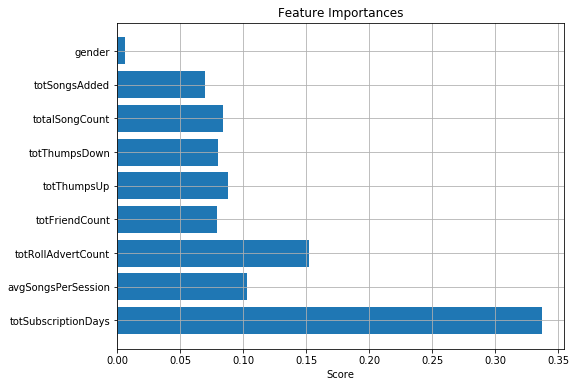

In [13]:
importantFeatures = bestModel.stages[-1].featureImportances.values
cols = ['totSubscriptionDays', 'avgSongsPerSession','totRollAdvertCount', 'totFriendCount','totThumpsUp', \
        'totThumpsDown','totalSongCount','totSongsAdded','gender']

y_pos = np.arange(len(cols))
plt.figure(figsize=(8,6))
plt.barh(y_pos,importantFeatures)
plt.yticks(y_pos, cols)
plt.grid()
plt.xlabel('Score')
plt.title('Feature Importances');
plt.savefig('featImportance_medium.png')